In [1]:
# # trim zuck audio
# import librosa
# filename = '../data/raw/z-c-feisty.wav'
# y, sr = librosa.load(filename, offset=64.0, duration=13.5)
# librosa.output.write_wav('zuck_trimmed.wav', y, sr)

In [2]:
# # trim audio from aaron ramsey. audio directly from VOXCeleb. aaron ramsey is the celeb with label 2/5993 in voxlb2_train.txt
# filename = 'Aaron Ramsey speaks to the press ahead of Wales v England.wav'
# y, sr = librosa.load(filename, offset=12.0, duration=15)
# librosa.output.write_wav('aaron_ramset.wav', y, sr)

In [3]:
# below is copied from taylorlu

import argparse
parser = argparse.ArgumentParser()
# set up training configuration.
parser.add_argument('--gpu', default='', type=str)
parser.add_argument('--resume', default=r'pretrained/weights.h5', type=str)
parser.add_argument('--data_path', default='4persons', type=str)
# set up network configuration.
parser.add_argument('--net', default='resnet34s', choices=['resnet34s', 'resnet34l'], type=str)
parser.add_argument('--ghost_cluster', default=2, type=int)
parser.add_argument('--vlad_cluster', default=8, type=int)
parser.add_argument('--bottleneck_dim', default=512, type=int)
parser.add_argument('--aggregation_mode', default='gvlad', choices=['avg', 'vlad', 'gvlad'], type=str)
# set up learning rate, training loss and optimizer.
parser.add_argument('--loss', default='softmax', choices=['softmax', 'amsoftmax'], type=str)
parser.add_argument('--test_type', default='normal', choices=['normal', 'hard', 'extend'], type=str)

global args
args = parser.parse_args(args=[])

In [1]:
import h5py
w1 = h5py.File(r'pretrained/weights.h5')
allKeys = w1.keys()
print(allKeys)



<KeysViewHDF5 ['activation_1', 'activation_10', 'activation_11', 'activation_12', 'activation_13', 'activation_14', 'activation_15', 'activation_16', 'activation_17', 'activation_18', 'activation_19', 'activation_2', 'activation_20', 'activation_21', 'activation_22', 'activation_23', 'activation_24', 'activation_25', 'activation_26', 'activation_27', 'activation_28', 'activation_29', 'activation_3', 'activation_30', 'activation_31', 'activation_32', 'activation_33', 'activation_34', 'activation_4', 'activation_5', 'activation_6', 'activation_7', 'activation_8', 'activation_9', 'add_1', 'add_10', 'add_11', 'add_2', 'add_3', 'add_4', 'add_5', 'add_6', 'add_7', 'add_8', 'add_9', 'conv1_1', 'conv2_a_1x1_increase', 'conv2_a_1x1_proj', 'conv2_a_1x1_reduce', 'conv2_a_3x3', 'conv2_b_1x1_increase', 'conv2_b_1x1_reduce', 'conv2_b_3x3', 'conv3_a_1x1_increase', 'conv3_a_1x1_proj', 'conv3_a_1x1_reduce', 'conv3_a_3x3', 'conv3_b_1x1_increase', 'conv3_b_1x1_reduce', 'conv3_b_3x3', 'conv3_c_1x1_increas

0
0.81245893 -0.39149654
1
0.3055826 -0.37269655
2
0.61857986 -0.25030577
3
0.22437176 -0.21256928
4
0.28413346 -0.1989144
5
0.21027732 -0.1575586
6
0.2861945 -0.31525993


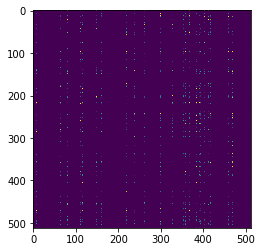

In [39]:
import matplotlib.pyplot as plt
a = w1['x_fc']['x_fc']['kernel:0']
for i in range(a.shape[0]):
    print(i)
    im = a[i,0,:,:]
    print(im.max(),im.min())
    plt.imshow(im,vmin=-0.0,vmax=0.1)

(7, 1, 512, 512)

In [4]:
import model
# ==================================
#       Get Train/Val.
# ==================================

unique_list = 'aaron_ramset.wav'

# ==================================
#       Get Model
# ==================================
# construct the data generator.
params = {'dim': (257, None, 1),
          'nfft': 512,
          'min_slice': 720,
          'win_length': 400,
          'hop_length': 160,
          'n_classes': 5994,
          'sampling_rate': 16000,
          'normalize': True,
          }

network_eval1 = model.vggvox_resnet2d_icassp(input_dim=params['dim'],
                                            num_class=params['n_classes'],
                                            mode='eval', args=args)
network_eval1.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 257, None, 1) 0                                            
__________________________________________________________________________________________________
conv1_1/3x3_s1 (Conv2D)         (None, 257, None, 64 3136        input[0][0]                      
__________________________________________________________________________________________________
conv1_1/3x3_s1/bn (BatchNormali (None, 257, None, 64 256         conv1_1/3x3_s1[0][0]             
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 257, None, 64 0           conv1_1/3x3_s1/bn[0][0]          
_____________________________________

In [5]:
import os
if args.resume:
    # ==> get real_model from arguments input,
    # load the model if the imag_model == real_model.
    if os.path.isfile(args.resume):
        network_eval1.load_weights(os.path.join(args.resume), by_name=True)
        print('==> successfully loading model {}.'.format(args.resume))
    else:
        raise IOError("==> no checkpoint found at '{}'".format(args.resume))
else:
    raise IOError('==> please type in the model to load')

print('==> start testing.')

==> successfully loading model pretrained/weights.h5.
==> start testing.


In [6]:
import preprocess
specs = preprocess.load_data(unique_list, split=False, win_length=params['win_length'], sr=params['sampling_rate'],
                     hop_length=params['hop_length'], n_fft=params['nfft'],
                     min_slice=params['min_slice'])

In [7]:
import numpy as np
specs = np.expand_dims(np.expand_dims(specs[0], 0), -1)
specs.shape

(1, 257, 1206, 1)

In [8]:
v = network_eval1.predict(specs)

In [9]:
import matplotlib.pyplot as plt
plt.plot(v[0,:])

In [ ]:
import h5py
w1 = h5py.File(r'pretrained/weights.h5')
allKeys = w1.keys()
print(allKeys)

'../models/speaker_embedding/train/VoxCeleb.SpeakerVerification.VoxCeleb1.train/weights/2000.pt'